In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

In [3]:
# he initializer using fan_out instead of fan_in
# variance scaling default is scale=1., mode='fan_in', distribution = 'trincated_normal' more detail read book p.415
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg',
                                                distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

In [4]:
# leakyrelu example
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[8]),
    keras.layers.Dense(10, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=.2)
])

In [5]:
# if we want to use prelu then change above LeakyReLU to PReLU()\
# if we want to use selu to activation function we can use like below:
layer = keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

In [6]:
# batch normalization in keras

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax'),
])

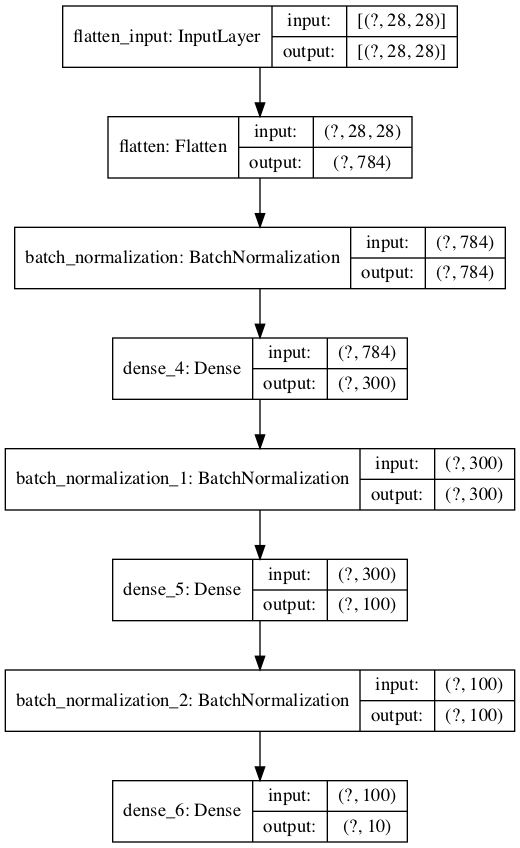

In [7]:
keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [9]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [10]:
model.layers[1].updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [11]:
model_batch_norm_before_activation = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(10, activation='softmax')
])

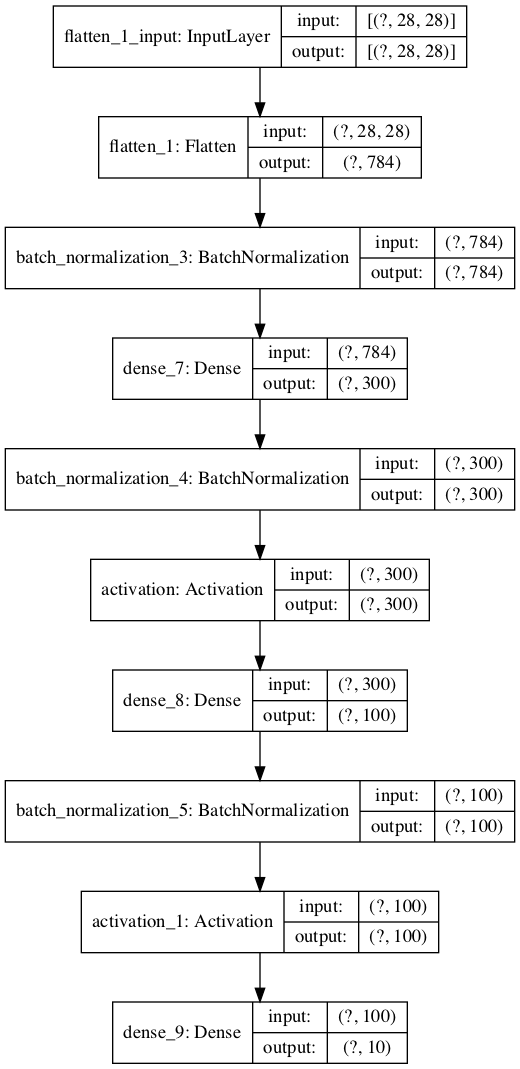

In [12]:
keras.utils.plot_model(model_batch_norm_before_activation,show_shapes=True)

In [13]:
model_batch_norm_before_activation.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_7 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [14]:
# to use gradient clipping in keras we can use like below:
# if we use clipvalue and clipnorm at the same time, then clipnorm apply first
optimizer = keras.optimizers.SGD(clipvalue=1.)
model.compile(loss='mse', optimizer=optimizer)

In [15]:
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [17]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [18]:
# transfer learning
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [19]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [20]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 4s 87us/sample - loss: 0.5902 - accuracy: 0.8131 - val_loss: 0.3784 - val_accuracy: 0.8692
Epoch 2/20
43986/43986 [==============================] - 3s 77us/sample - loss: 0.3517 - accuracy: 0.8784 - val_loss: 0.3369 - val_accuracy: 0.8832
Epoch 3/20
43986/43986 [==============================] - 3s 75us/sample - loss: 0.3163 - accuracy: 0.8896 - val_loss: 0.3017 - val_accuracy: 0.8959
Epoch 4/20
43986/43986 [==============================] - 3s 77us/sample - loss: 0.2969 - accuracy: 0.8972 - val_loss: 0.2912 - val_accuracy: 0.9028
Epoch 5/20
43986/43986 [==============================] - 3s 76us/sample - loss: 0.2831 - accuracy: 0.9027 - val_loss: 0.2816 - val_accuracy: 0.9018
Epoch 6/20
43986/43986 [==============================] - 3s 74us/sample - loss: 0.2725 - accuracy: 0.9066 - val_loss: 0.2737 - val_accuracy: 0.9071
Epoch 7/20
43986/43986 [==============================] -

In [21]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])

In [22]:
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

In [23]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [24]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False
    
model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd',
                    metrics=['accuracy'])

In [25]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                          validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=['accuracy'])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                          validation_data=(X_valid_B,y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 2ms/sample - loss: 0.8795 - accuracy: 0.6100 - val_loss: 0.6036 - val_accuracy: 0.6897
Epoch 2/4
200/200 [==============================] - 0s 262us/sample - loss: 0.4332 - accuracy: 0.7850 - val_loss: 0.3403 - val_accuracy: 0.8387
Epoch 3/4
200/200 [==============================] - 0s 276us/sample - loss: 0.2485 - accuracy: 0.9350 - val_loss: 0.2294 - val_accuracy: 0.9371
Epoch 4/4
200/200 [==============================] - 0s 257us/sample - loss: 0.1704 - accuracy: 0.9650 - val_loss: 0.1739 - val_accuracy: 0.9574
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 0s 2ms/sample - loss: 0.1384 - accuracy: 0.9750 - val_loss: 0.1689 - val_accuracy: 0.9604
Epoch 2/16
200/200 [==============================] - 0s 324us/sample - loss: 0.1343 - accuracy: 0.9800 - val_loss: 0.1643 - val_accuracy: 0.9655
Epoch 3/16
200/200 [====================

In [26]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 36us/sample - loss: 0.1350 - accuracy: 0.9665


[0.13502171915769576, 0.9665]

In [27]:
# momentum in keras
optimizer = keras.optimizers.SGD(lr=.001, momentum=.9)

In [28]:
# nesterov accelerated gradient(nestrov momentum optimization)
# almost nag is faster than momentum
# nag in keras
optimizer = keras.optimizers.SGD(lr=.001, momentum=.9, nesterov=True)

In [29]:
# AdaGrad
optimizer = keras.optimizers.Adagrad(learning_rate=.001)

In [30]:
#RMSprop
optimizer = keras.optimizers.RMSprop(learning_rate=.001, rho=.9)

In [31]:
# Adam
optimizer = keras.optimizers.Adam(lr=.001, beta_1=.9, beta_2=.999)

In [33]:
optimizer = keras.optimizers.SGD(lr=.01, decay=1e-4)

In [36]:
def exponential_decay_fn(epochs):
    return 0.01 * 0.1**(epochs/20)

In [37]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn
exponential_decay_fn = exponential_decay(lr0=.01, s=20)

In [38]:
exponential_decay_fn

<function __main__.exponential_decay.<locals>.exponential_decay_fn(epoch)>

In [39]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)


In [40]:
# l2 
layer = keras.layers.Dense(100, activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(.01))

In [41]:
# fuctools partial
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax',
                    kernel_initializer='glorot_uniform')
])

In [42]:
# drop out
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=.2),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=.2),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=.2),
    keras.layers.Dense(10, activation='softmax')
])

In [43]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [44]:
# monte carlo dropout

y_probas = np.stack([model(X_test_scaled,training= True) for sample in range(100) ])
y_proba = y_probas.mean(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [45]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)